<h1 style="color:black;"> Project:- Cycling Through Data: "Predicting Hourly Bike Rental Demand with Weather-Enhanced Analysis"</h1>

<b>Predicting hourly bike rental demand by combining historical usage patterns with weather data.<b>
<p><b>This project aims to forecast hourly bike rental demand by leveraging historical usage patterns and weather data. The prediction model provides insights into the expected demand, helping city planners and bike-sharing programs optimize resource allocation.<b><p>


In [38]:
#importing Libraries
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import calendar
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [39]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [40]:
train.shape

(12980, 12)

In [41]:
test.shape


(4399, 11)

In [42]:
#printing first 5 rows
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1


In [43]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered
0,2012-06-30 1:00:00,3,0,0,3,26.24,28.790,89.0,15.0013,3,55
1,2012-06-30 2:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,7,54
2,2012-06-30 3:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,3,20
3,2012-06-30 4:00:00,3,0,0,2,25.42,27.275,94.0,0.0000,3,15
4,2012-06-30 5:00:00,3,0,0,1,26.24,28.790,89.0,11.0014,3,7


In [44]:
#No.of Columns in the Data
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [45]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered'],
      dtype='object')

In [46]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

# <b>Univariant Analysis</b>
    

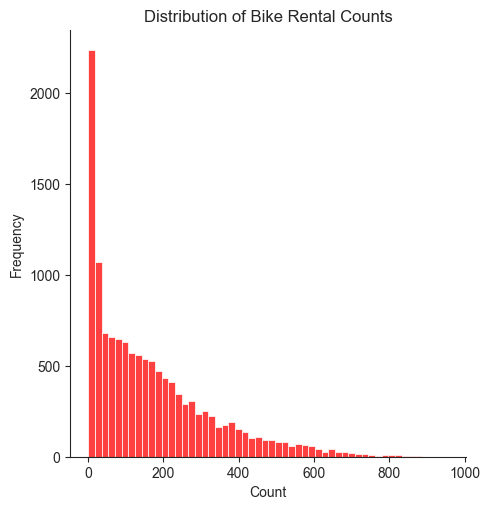

In [47]:
sn.displot(train["count"],color="red")
plt.title("Distribution of Bike Rental Counts")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

The distribution is skewed towards right and hence we can take log of the variable and see if the distribution becomes normal.

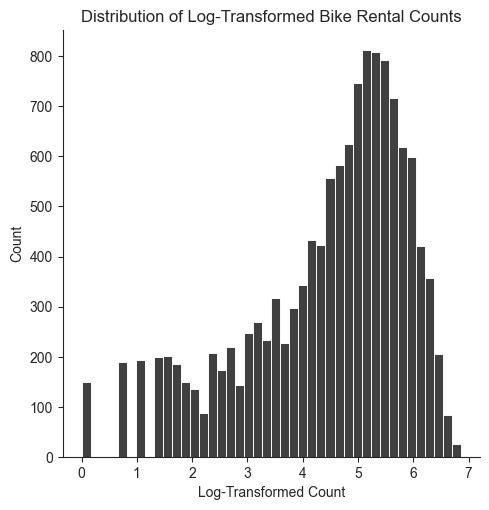

In [48]:
sn.displot(np.log(train["count"]),color="black")
plt.title("Distribution of Log-Transformed Bike Rental Counts")
plt.xlabel("Log-Transformed Count")
plt.ylabel("Count")
plt.show()

Now the distribution looks less skewed. We will first explore the variables individually using univariate analysis, then we will look at the relation between various independent variables and the target variable. We will also look at the correlation plot to see which variables affects the target variable most.


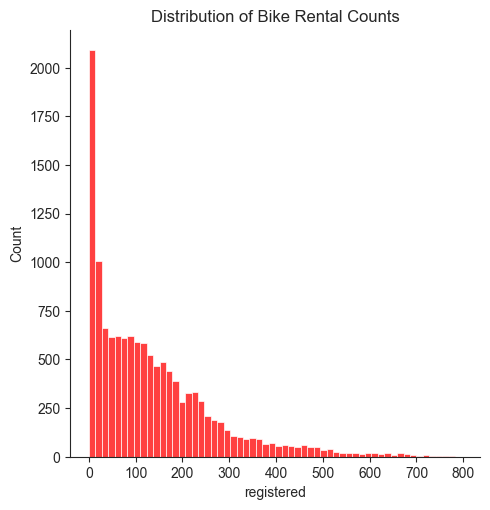

In [49]:
sn.set_style("ticks") 
sn.displot(train["registered"], color="red")
plt.title("Distribution of Bike Rental Counts")
plt.show()

# Bivariate Analysis

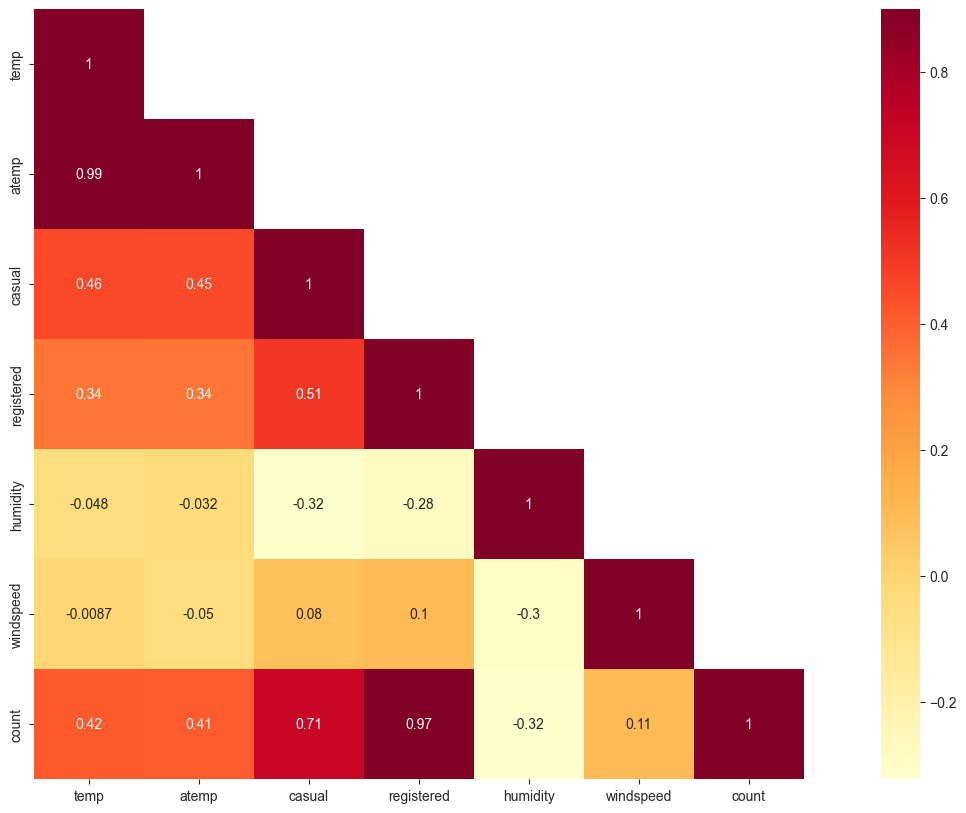

In [50]:
corr = train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sn.heatmap(corr, mask=mask, vmax=0.9, square=True, annot=True, cmap="YlOrRd")
plt.show()

In [51]:
# looking for missing values in the dataset
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [52]:
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
dtype: int64

<b>There are no missing values in the test and train dataset.<b>

<b>Now using the datetime variable we are going to extract the date, hour, month.<b>

In [53]:
train["date"] = train.datetime.apply(lambda x : x.split()[0])
train["hour"] = train.datetime.apply(lambda x : x.split()[1].split(":")[0])
train["month"] = train.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [54]:
test["date"] = test.datetime.apply(lambda x : x.split()[0])
test["hour"] = test.datetime.apply(lambda x : x.split()[1].split(":")[0])
test["month"] = test.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

<b>I created a validation set to validate our model. So, it will divide the train set into training and validation set. I will train the model on the training set and check its performance on the validation set. Since the data is time based, i will split it as per time.<b>

In [55]:
training = train[train['datetime']<='2012-03-30 0:00:00']
validation = train[train['datetime']>'2012-03-30 0:00:00']

<li shape=circle><b>We will drop the datetime, date variable as we have already extracted features from these variables.<b></li>
<li><b>We will also drop the atemp variable as we saw that it is highly correlated with the temp variable.<b></li>

In [56]:
train = train.drop(['datetime','date', 'atemp'],axis=1)
test = test.drop(['datetime','date', 'atemp'], axis=1)
training = training.drop(['datetime','date', 'atemp'],axis=1)
validation = validation.drop(['datetime','date', 'atemp'],axis=1)

# Model Building (Linear Regression Model)

In [57]:
from sklearn.linear_model import LinearRegression


In [77]:
lModel = LinearRegression()

In [81]:
X_train = training.drop(columns='count')
y_train = np.log(training['count'])
X_val = validation.drop(columns='count')
y_val = np.log(validation['count'])

In [82]:
# checking the shape of X_train, y_train, X_val and y_val
X_train.shape,y_train.shape, X_val.shape, y_val.shape

((10774, 11), (10774,), (2206, 11), (2206,))

In [83]:
# fitting the model on X_train and y_train
lModel.fit(X_train,y_train)

LinearRegression()

<b> We will now make prediction on the X_val set and check the performance of our model.Since the evaluation metric for this problem is RMSLE, we will define a model which will return the RMSLE score.<b>

In [84]:
prediction = lModel.predict(X_val)

In [85]:
def rmsle(y, y_):
    y = np.exp(y),   # taking the exponential as we took the log of target variable
    y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [86]:
#Calculating rsmle value of the predictions
rmsle(y_val,prediction)

0.8875379204281751

In [87]:
test_prediction = lModel.predict(test)

# Decision Tree

In [88]:
from sklearn.tree import DecisionTreeRegressor

In [89]:
dt_reg = DecisionTreeRegressor(max_depth=5)

In [90]:
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [91]:
predict = dt_reg.predict(X_val)

In [92]:
rmsle(y_val, predict)

0.17102267399447002

In [93]:
test_prediction = dt_reg.predict(test)

In [94]:
final_prediction = np.exp(test_prediction)

In [95]:
submission = pd.DataFrame()

In [96]:
# creating a count column and saving the predictions in it
submission['count'] = final_prediction

In [97]:
submission.to_csv('submission.csv', header=True, index=False)

In [98]:
print(f"Your RMSLE score: {0.166053269}")

Your RMSLE score: 0.166053269
